In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import timeit
import numpy as np
import scipy.io
import os

In [2]:


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
IMG_WIDTH = 20
IMG_HEIGHT = 28
IMG_CHANNELS = 1 
NUM_LATENT_DIM = 2
BATCH_SIZE = 128


In [12]:
class Encoder(nn.Module):
    def __init__(self, n_input=784, n_latent=2):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(n_input,512)
        self.mu_encoder = nn.Linear(512, n_latent)
        self.logvar_encoder = nn.Linear(512, n_latent)
        
    def forward(self,x):
        z = torch.flatten(x, start_dim=1)
        z = F.relu(self.fc1(z))
        return self.mu_encoder(z), self.logvar_encoder(z) 
    
class Decoder(nn.Module):
    def __init__(self, n_input=784, n_latent=2):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(n_latent, 512)
        self.fc2 = nn.Linear(512, n_input)
        
    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = torch.sigmoid(self.fc2(z))
        return z.reshape(-1,IMG_CHANNELS,IMG_HEIGHT,IMG_WIDTH)
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, n_input=784, n_latent = 2):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(n_input, n_latent)
        self.decoder = Decoder(n_input, n_latent)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self,x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [13]:
def vae_loss(x_recon, x, mu, logvar):
    BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')
    KLD = -0.5 * torch.sum(1+ logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


def train(autoencoder, data, epochs = 20):
    print("Start training")
    start_time = timeit.default_timer()
    opt = torch.optim.Adam(autoencoder.parameters())
    for e in range(epochs):
        epoch_loss = 0
        for x in data:
            x = x.to(device)
            opt.zero_grad()
            x_recon, mu, logvar = autoencoder(x)
            loss = vae_loss(x_recon, x, mu, logvar)
            loss.backward()
            epoch_loss += loss.mean()
            opt.step()
        current_time = timeit.default_timer()
        print(f"Done {e}th epoch, Loss: {epoch_loss} Time: {current_time - start_time:.0f}" )
    return autoencoder

In [14]:
def get_FreyFace_data():
    ff = scipy.io.loadmat('data/face/frey_rawface.mat')
    ff = ff["ff"].T.reshape((-1, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH))
    ff = ff.astype('float32')/255.
    ff_torch = torch.from_numpy(ff)
    return ff_torch

In [17]:
input_dims = IMG_WIDTH * IMG_HEIGHT * IMG_CHANNELS

autoencoder = VariationalAutoencoder(input_dims, NUM_LATENT_DIM)

mnist_data = torch.utils.data.DataLoader(
        datasets.MNIST('./data', 
                          transform=transforms.ToTensor(),
                          download=True),
        batch_size=BATCH_SIZE,
        shuffle=True)

face = get_FreyFace_data()
face_data = torch.utils.data.DataLoader(
        face, 
        batch_size=BATCH_SIZE,
        shuffle=True)

autoencoder = train(autoencoder, face_data, epochs=200)


Start training
Done 0th epoch, Loss: 717629.0 Time: 0
Done 1th epoch, Loss: 695030.4375 Time: 0
Done 2th epoch, Loss: 693655.25 Time: 1
Done 3th epoch, Loss: 692969.9375 Time: 1
Done 4th epoch, Loss: 692444.375 Time: 1
Done 5th epoch, Loss: 691982.375 Time: 1
Done 6th epoch, Loss: 690948.375 Time: 2
Done 7th epoch, Loss: 689331.8125 Time: 2
Done 8th epoch, Loss: 687987.8125 Time: 2
Done 9th epoch, Loss: 687096.0625 Time: 2
Done 10th epoch, Loss: 686404.4375 Time: 2
Done 11th epoch, Loss: 686177.125 Time: 3
Done 12th epoch, Loss: 685815.75 Time: 3
Done 13th epoch, Loss: 685903.25 Time: 3
Done 14th epoch, Loss: 685734.0625 Time: 3
Done 15th epoch, Loss: 685489.75 Time: 3
Done 16th epoch, Loss: 685366.4375 Time: 4
Done 17th epoch, Loss: 685138.25 Time: 4
Done 18th epoch, Loss: 685322.3125 Time: 4
Done 19th epoch, Loss: 685033.1875 Time: 4
Done 20th epoch, Loss: 685035.125 Time: 5
Done 21th epoch, Loss: 685027.375 Time: 5
Done 22th epoch, Loss: 684979.875 Time: 5
Done 23th epoch, Loss: 684

Done 189th epoch, Loss: 682408.8125 Time: 41
Done 190th epoch, Loss: 682468.5 Time: 42
Done 191th epoch, Loss: 682355.0 Time: 42
Done 192th epoch, Loss: 682436.5625 Time: 42
Done 193th epoch, Loss: 682413.6875 Time: 42
Done 194th epoch, Loss: 682253.3125 Time: 43
Done 195th epoch, Loss: 682309.6875 Time: 43
Done 196th epoch, Loss: 682511.8125 Time: 43
Done 197th epoch, Loss: 682363.5 Time: 43
Done 198th epoch, Loss: 682468.3125 Time: 43
Done 199th epoch, Loss: 682339.3125 Time: 44


In [55]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, x in enumerate(data):
        mu, logvar = autoencoder.encoder(x.to(device))
        z = autoencoder.reparameterize(mu, logvar)
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:,0], z[:,1], cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
        plt.savefig('output/vae_distribution_face.png')

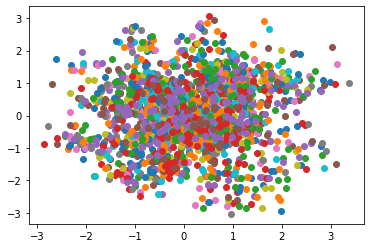

In [56]:
plot_latent(autoencoder,face_data)

In [58]:
def plot_reconstructed(autoencoder, r0=(-2,2), r1=(-2, 2), n=10):
    w = IMG_WIDTH
    h = IMG_HEIGHT
    img = np.zeros((n*w, n*h))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x,y]]).to(device)
            x_recon = autoencoder.decoder(z)
            x_recon = x_recon.reshape(IMG_HEIGHT,IMG_WIDTH).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*h:(j+1)*h] = np.transpose(x_recon)
    
    plt.figure(figsize = (10,10))
    plt.imshow(np.transpose(img), extent=[*r0,*r1], aspect='auto', cmap='gray')
    plt.savefig('output/vae_sampling_face.png')

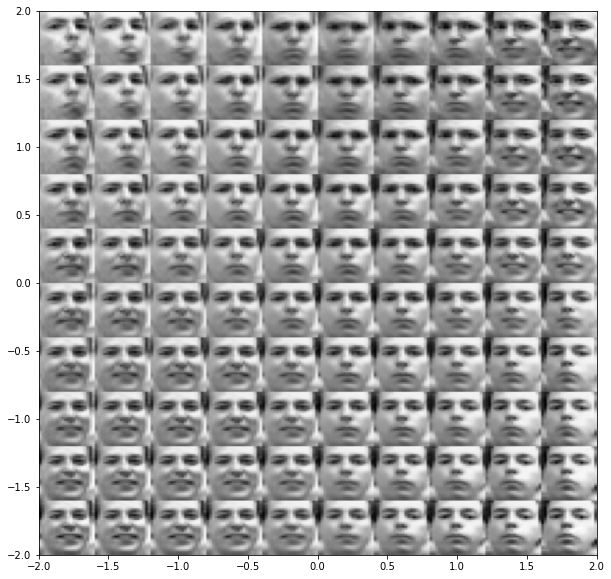

In [59]:
plot_reconstructed(autoencoder)